# Feeling Detection using Deep Learning NLP

This deep learning program is designed to classify emotions from text input into three categories: Bahagia, Sedih, and Marah. We use a dataset with labeled texts for training, validation, and testing. The model is built using TensorFlow and includes an embedding layer, LSTM layer, and dense layers. We also use GloVe embeddings to improve accuracy.


The program includes a custom callback to stop training if validation accuracy reach 80%. Finally, we can input text directly into the program and see the predicted emotion using a simple user interface. The model will be converted into H5 and TensorFlow.js (JSON) formats for deployment by the Cloud Computing Team. This model will also be used in an Android mobile application, SereLuna.

### Import Library

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [2]:
!pip install pandas nltk tensorflow scikit-learn keras-tuner

In [3]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt

## Load Dataset

Loads the dataset from a CSV file named 'dataset-feeling.csv' and checks its columns. It prints the column names to ensure the dataset structure. The code then verifies that the dataset contains the required columns 'Teks' and 'Label'. If these columns are missing, it raises an error.

In [4]:
# Load dataset from CSV
dataset = pd.read_csv('dataset-feeling.csv')

# Check columns
print("Columns in the dataset:", dataset.columns)

# Check if dataset contains the required columns
if 'Teks' not in dataset.columns or 'Label' not in dataset.columns:
    raise ValueError("The dataset must contain 'Teks' and 'Label' columns.")

Columns in the dataset: Index(['Teks', 'Label'], dtype='object')


## Data Preprocessing

Performs text preprocessing. It first downloads necessary NLTK resources for lemmatization and stopwords. A list of Indonesian stopwords is created. The clean_text function is defined to normalize text by converting to lowercase, removing short words, digits, punctuation, and extra spaces. The preprocess_text function uses clean_text and further processes the text by removing stopwords and applying lemmatization. Finally, the dataset's 'Teks' column is processed using these functions.

In [5]:
nltk.download('wordnet')
nltk.download('stopwords')

# Daftar stop words Bahasa Indonesia
stop_words_id = set(stopwords.words('indonesian'))

# Clean the texts
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)  # remove short words
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = clean_text(text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words_id]
    return ' '.join(words)

dataset['Teks'] = dataset['Teks'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Normalization

Splits the dataset into texts and labels. Then, it tokenizes the texts using a Tokenizer with a maximum of 5000 words and converts the texts to sequences of integers. The tokenizer's word index is saved to a JSON file. Next, the sequences are padded to ensure they all have the same length, with a maximum length of 50. Finally, the labels are converted to a NumPy array.

In [6]:
# Split texts and labels
texts = dataset['Teks'].tolist()
labels = dataset['Label'].tolist()

# Tokenizing
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Save the tokenizer
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer.to_json(), f)

# Padding
maxlen = 50
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.array(labels)

Loads GloVe embeddings to enhance the model's performance. It defines a function load_glove_embeddings to read the embeddings from a file and create a dictionary mapping words to their vector representations. The code then downloads and unzips the GloVe embeddings. The glove_path is set to the 50-dimensional GloVe file. Finally, an embedding matrix is created, where each word in the tokenizer's word index is mapped to its corresponding GloVe vector, if available.

In [7]:
# Load GloVe embeddings
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Download GloVe embeddings if not already done
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove

glove_path = 'glove/glove.6B.50d.txt'
embeddings_index = load_glove_embeddings(glove_path)

embedding_dim = 50
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

--2024-06-21 06:20:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-21 06:20:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-21 06:20:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Split Dataset

In [8]:
# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

## Model Building

We define our deep learning model for text classification into three classes. We use an embedding layer initialized with GloVe embeddings, followed by a spatial dropout layer. We include three LSTM layers to capture sequential patterns in the text data, with the last LSTM layer returning sequences. A global max pooling layer reduces the dimensionality, followed by a dense layer with ReLU activation and a dropout layer to prevent overfitting. Finally, we use a dense layer with softmax activation to output probabilities for the three classes.

In [9]:
# Define the model with three classes
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),  # Second LSTM layer
    tf.keras.layers.LSTM(32, return_sequences=True),  # Third LSTM layer with return_sequences=True
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer for 3 classes with softmax activation
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            128900    
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 50, 64)            29440     
                                                                 
 lstm_1 (LSTM)               (None, 50, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 50, 32)            12416     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                        

## Compile Model

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Train Model

We train our deep learning model. We define a custom callback, StopEpoch, which stops training when the accuracy exceeds 85% and validation accuracy exceeds 80%. We instantiate this callback and then train the model for up to 500 epochs with a batch size of 512, using the training and validation data. The custom callback will ensure that training stops early if the target accuracies are reached.

In [11]:
# Define a custom callback to stop training when accuracy and validation accuracy reach 95%
class StopEpoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy is not None and val_accuracy is not None:
            if accuracy > 0.85 and val_accuracy > 0.80:
                print(f"\nStopping training as accuracy ({accuracy*100:.2f}%) and validation accuracy ({val_accuracy*100:.2f}%) have reached target")
                self.model.stop_training = True

# Instantiate the custom callback
stop_epoch= StopEpoch()

# Training the model
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), batch_size=512, callbacks=[stop_epoch])

Epoch 1/500
2/2 [==============================] - 20s 4s/step - loss: 1.1053 - accuracy: 0.2754 - val_loss: 1.0951 - val_accuracy: 0.4435
Epoch 2/500
2/2 [==============================] - 1s 757ms/step - loss: 1.0943 - accuracy: 0.4105 - val_loss: 1.0859 - val_accuracy: 0.5146
Epoch 3/500
2/2 [==============================] - 1s 739ms/step - loss: 1.0850 - accuracy: 0.4775 - val_loss: 1.0756 - val_accuracy: 0.4979
Epoch 4/500
2/2 [==============================] - 1s 750ms/step - loss: 1.0755 - accuracy: 0.4827 - val_loss: 1.0627 - val_accuracy: 0.4937
Epoch 5/500
2/2 [==============================] - 1s 726ms/step - loss: 1.0649 - accuracy: 0.4817 - val_loss: 1.0464 - val_accuracy: 0.4937
Epoch 6/500
2/2 [==============================] - 1s 737ms/step - loss: 1.0497 - accuracy: 0.4942 - val_loss: 1.0263 - val_accuracy: 0.4937
Epoch 7/500
2/2 [==============================] - 1s 722ms/step - loss: 1.0352 - accuracy: 0.4995 - val_loss: 1.0081 - val_accuracy: 0.4937
Epoch 8/500
2/2

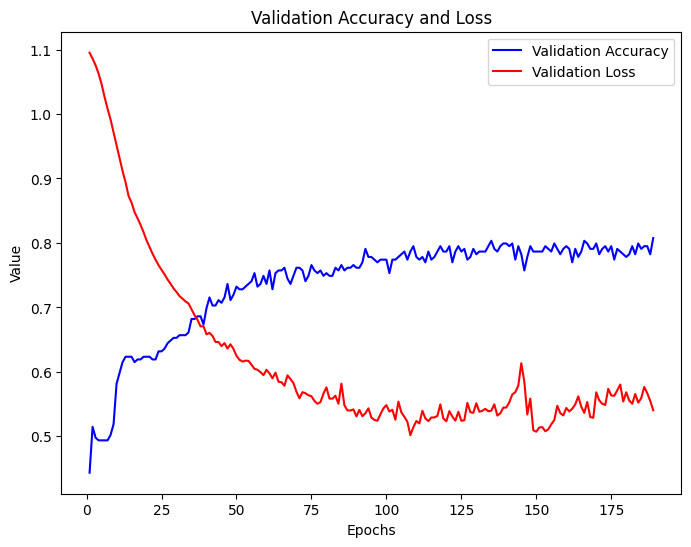

In [12]:
import matplotlib.pyplot as plt

# Retrieve the history dictionary
history_dict = history.history

# Extract accuracy and loss for validation
val_acc = history_dict['val_accuracy']
val_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(val_acc) + 1)

# Plot validation accuracy and loss in one figure
plt.figure(figsize=(8, 6))
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

## Evaluate Model

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

5/5 [==============================] - 0s 39ms/step - loss: 0.5628 - accuracy: 0.8120
Test Accuracy: 81.20%


## Tuning

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.LSTM(units=hp.Int('units_' + str(i), min_value=64, max_value=256, step=64),
                                       dropout=hp.Float('dropout_' + str(i), 0.1, 0.5, step=0.1),
                                       recurrent_dropout=hp.Float('recurrent_dropout_' + str(i), 0.1, 0.5, step=0.1),
                                       return_sequences=True))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_dense', 0.1, 0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory='my_dir',
    project_name='emotion_detection_bayesian'
)

tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Retrain the best model on the full training data
best_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

# Save the best model
best_model.save('feeling_detection_model_2.h5')

Reloading Tuner from my_dir/emotion_detection_bayesian/tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            128900    
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 50, 192)           186624    
                                                                 
 global_max_pooling1d (Glob  (None, 192)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               24704     
                                                       

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

5/5 [==============================] - 0s 31ms/step - loss: 0.6710 - accuracy: 0.7895
Test Accuracy: 78.95%


### Download Model ke Lokal

Download Model h5 Non-Tuning

In [ ]:
# Save Model Non-Tuning
model.save('feeling_detection_model_notuning_2.h5')

In [ ]:
from google.colab import files

# Unduh file langsung ke komputer lokal
files.download('feeling_detection_model_notuning_2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download Model h5 Tuning

In [ ]:
from google.colab import files

# Unduh file langsung ke komputer lokal
files.download('feeling_detection_model_2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Save Model

In [14]:
# The best model is already saved after tuning
# Save the tokenizer
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer.to_json(), f)

## Deployment on Colab

In [ ]:
# Load the model
model = tf.keras.models.load_model('feeling_detection_model.h5') #ini bisa diganti h5 tuning atau non-tuning

def preprocess_text_for_prediction(text, tokenizer, maxlen):
    text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)
    return padded_sequence

import ipywidgets as widgets
from IPython.display import display

def get_user_input_and_predict(model, tokenizer, maxlen):
    text_box = widgets.Textarea(
        value='',
        placeholder='Masukkan teks di sini...',
        description='Input:',
        disabled=False
    )
    submit_button = widgets.Button(description="Prediksi")
    output = widgets.Output()

    def on_button_click(b):
        with output:
            output.clear_output()
            input_text = text_box.value
            preprocessed_text = preprocess_text_for_prediction(input_text, tokenizer, maxlen)
            prediction = model.predict(preprocessed_text)
            predicted_label = np.argmax(prediction, axis=1)[0]
            emotion_labels = ["Bahagia", "Sedih", "Marah"]
            result = emotion_labels[predicted_label]
            print(f'Teks: "{input_text}"')
            print(f'Prediksi: {result}')

    submit_button.on_click(on_button_click)

    display(text_box, submit_button, output)

get_user_input_and_predict(model, tokenizer, maxlen)

Textarea(value='', description='Input:', placeholder='Masukkan teks di sini...')

Button(description='Prediksi', style=ButtonStyle())

Output()

In [ ]:
import json

# Path ke file tokenizer.json
json_file_path = 'tokenizer.json'

# Memuat isi file JSON
with open(json_file_path, 'r') as json_file:
    tokenizer_data = json.load(json_file)

# Menampilkan struktur dari tokenizer_data
print(json.dumps(tokenizer_data, indent=2))

{
  "class_name": "Tokenizer",
  "config": {
    "num_words": 5000,
    "filters": "!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n",
    "lower": true,
    "split": " ",
    "char_level": false,
    "oov_token": null,
    "document_count": 1327,
    "word_counts": "{\"berjalan\": 27, \"bahagia\": 107, \"menikmati\": 153, \"santai\": 10, \"keluarga\": 136, \"tidur\": 10, \"pikiran\": 45, \"berjalanjalan\": 31, \"tugas\": 25, \"diselesaikan\": 4, \"cemas\": 10, \"pekerjaan\": 31, \"melelahkan\": 7, \"sistem\": 3, \"komputer\": 1, \"mengalami\": 11, \"gangguan\": 10, \"lingkungan\": 21, \"kerja\": 151, \"nyaman\": 32, \"gaji\": 5, \"terima\": 12, \"sesuai\": 9, \"beban\": 26, \"ruang\": 22, \"kantor\": 33, \"berantakan\": 21, \"kotor\": 1, \"rapat\": 5, \"molor\": 1, \"efisien\": 4, \"atasan\": 23, \"menghargai\": 23, \"usaha\": 52, \"internet\": 3, \"lambat\": 8, \"istirahat\": 10, \"rekan\": 35, \"kooperatif\": 2, \"aplikasi\": 2, \"sulit\": 66, \"dipahami\": 2, \"proyek\": 39, \"memiliki\": 30,